# Análisis estación meteorológica #

## Carga de librerias ##


In [1]:
from IPython.display import display, HTML

import json
import os
import glob
import math
from itertools import product
import datetime as dt

#from pytz import timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy import stats


%matplotlib inline
plt.rcParams['figure.figsize'] = (16,4)

base_path = os.path.normpath('D:/Dcorporativo/MeteoEstaciones')

# Graficas de vientos #
## Cargar datos de rosa de los vientos ##
Datos de puntos cardinales con sus respecticas direcciones y nombres


## Definir grafico de rosa de los vientos ##
Definicion de la grafica de rosa de los vientos para ser utilizada posteriormente.

In [2]:
compass_path = os.path.join(os.path.normpath('D:/Dcorporativo'), 'compass_rose.json')
compass = pd.read_json(compass_path).T.sort_values('heading')
with open(compass_path) as src:
    compass = json.load(src)
    
compass = pd.read_json(compass_path).T.sort_values('heading')

display(compass)


def plot_wind(data, comp, wind_speed_cats, wind_speed='ws', wind_heading='wd', cmap_name='cool'):
    
    df = data[[wind_speed, wind_heading]].copy()
    
    #Cut WindSpeed into categories
    df['Categoria'] = pd.cut(df[wind_speed], bins=wind_speed_cats['edges'], labels=wind_speed_cats['names'], include_lowest=True)
    n_wind_cats = len(wind_speed_cats['names'])
    
    #Cut WindHeading into categories
    comp.index.name = 'point'
    comp = comp.sort_values(by='heading')
    comp['heading_rad'] = comp['heading'].apply(lambda x: math.radians(x))
    n_headings = len(comp)
    
    edge_step_width = 360/n_headings/2    
    
    
    wd_edges = (comp['heading'] + edge_step_width).tolist()
    wd_edges.insert(0,0)
    wd_edges.append(360)
    c_points = comp.index.tolist()
    first_heading = c_points[0]
    c_points.append(first_heading + 'X')
    
    
    
    df['point'] = pd.cut(df[wind_heading], bins=wd_edges, labels=c_points, include_lowest=True)
    df.loc[df['point'] == first_heading + 'X', 'point'] = first_heading
    
    #display(df)
    
    
    # Reshape and merge
    plot_data = df.groupby(['point', 'Categoria']).size().to_frame('frecuencia').reset_index().pivot(index='point', columns='Categoria', values='frecuencia')/len(df)
    #display(plot_data)
    plot_data = pd.merge(comp, plot_data, how='left', left_index=True, right_index=True)
    #display(plot_data)
    
    # plot Data
    
    # force square figure and square axes looks better for polar, IMO
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
    
    
    cmap = plt.cm.get_cmap(cmap_name)
    bar_ls = []
    print("n_headings", n_headings)
    for i, cat in enumerate(reversed(wind_speed_cats['names'])):
        width_factor = (i+1)/n_wind_cats
        width = width_factor*0.8*2*np.pi/n_headings
        color = cmap(i/n_wind_cats)
        alpha = 1/n_wind_cats
        alpha = 0.33
        
        bars = ax.bar(plot_data['heading_rad'], height=plot_data[cat], width=width, alpha=alpha, color=color, edgecolor='black')
        bar_ls.append(bars)
        
    ax.set_xticks(plot_data['heading_rad'])
    ax.set_xticklabels(plot_data.index)
    #ax.set_yticks([])
    ax.yaxis.set_major_formatter(FuncFormatter(lambda val, _: '{:.0%}'.format(val))) 
    #ax.set_yticklabels(None)

    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")
    cat_edges = wind_speed_cats['edges']
    cat_intervals = [(cat_edges[i], cat_edges[i+1]) for i in range(n_wind_cats)]
    label_names = [f"{tup[0]} - ({tup[1][0]:0.2f}, {tup[1][1]:0.2f}] m/s" for tup in zip(wind_speed_cats['names'], cat_intervals)]
    ax.legend(bar_ls, label_names)
    #ax.grid(False)
    
    return(plot_data)

,compass point,heading,level,traditional wind point
N,North,0,0,Tramontana
NbE,North by east,11.25,3,Quarto di Tramontana verso Greco
NNE,North-northeast,22.5,2,Greco-Tramontana
NEbN,Northeast by north,33.75,3,Quarto di Greco verso Tramontana
NE,Northeast,45,1,Greco
NEbE,Northeast by east,56.25,3,Quarto di Greco verso Levante
ENE,East-northeast,67.5,2,Greco-Levante
EbN,East by north,78.75,3,Quarto di Levante verso Greco
E,East,90,0,Levante
EbS,East by south,101.25,3,Quarto di Levante verso Scirocco


## Carga de datos de la estación ##

### Nombre de la estación ###
Corresponde con el nombre de la carpeta en el `base_path`.


In [20]:
estacion = 'fabrica_chocolate'
estacion = 'montebello'
estacion = 'dann_cali'


estaciones = {
    "montebello": {"archivo": '*', "sep": ','},
    "dann_cali": {"archivo": '*.dat', "sep": ','},
    "compartir": {"archivo": '*.dat', "sep": ','},
    "jardin_plaza": {"archivo": '*.dat', "sep": ','},
#     "fabrica_chocolate": {"archivo": '*'},
}

usecols = [
    'TIMESTAMP'
    , 'DireccionViento'
    , 'VelocidadViento_Avg'
    , 'TempAire'
    , 'HumAire'
    , 'PuntoRocio'
    , 'PresionAtm'
    , 'IntensidaPreci'
    , 'TotalPreci_Tot'
    , 'SlrkW_Avg'#, 'SlrkW_Max', 'SlrkW_Min', 'SlrkW', 'SlrkW_Std'
    , 'SlrkW2_Avg'#, 'SlrkW2_Max', 'SlrkW2_Min', 'SlrkW2', 'SlrkW2_Std'
]

data_st = {}
for estacion in estaciones:
    dfs = []
    src_path = os.path.join(base_path,'Data', estacion, estaciones[estacion]['archivo'])
    for i, p in enumerate(glob.glob(src_path)):
        print(f"Procesando archivo {p}")
        if i==0:
            variables = pd.read_csv(p, 
                                    sep=estaciones[estacion]['sep'],
                                    index_col=0,
                                    skiprows=1,
                                    header=None,
                                    nrows=3)
            variables = variables.T
            variables.columns = ['var', 'units', 'method']
            variables = variables.set_index('var').dropna()
            variables = variables.T
            variables = variables.to_dict(orient='dict')
            display(variables)

#         try:
        temp = pd.read_csv(p,
                           sep=estaciones[estacion]['sep'],
                           header=1,
                           skiprows=[2,3],
                           usecols=usecols,
                           na_values=['NAN'],
                           parse_dates={'TS': [0]})
        
        dfs.append(temp)
    
    if dfs:
        data = pd.concat(dfs)
        #display(data[data.duplicated(subset='TS', keep=False)].sort_values('TS'))
        data = data.drop_duplicates(subset='TS')
        data = data.set_index('TS', drop=True).asfreq('1min')
        data_st[estacion] = data


for st, data in data_st.items():
    print(f"{st.upper():*^80}")
    display(data.head())

Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\montebello\20180131 Montebello_DatosMin.dat


{'DireccionViento': {'method': 'Smp', 'units': 'Degree'},
 'HumAire': {'method': 'Smp', 'units': '%'},
 'IntensidaPreci': {'method': 'Smp', 'units': 'mm/h'},
 'PresionAtm': {'method': 'Smp', 'units': 'mB'},
 'PuntoRocio': {'method': 'Smp', 'units': 'Deg C'},
 'SlrkW': {'method': 'Smp', 'units': 'W/m^2'},
 'SlrkW2': {'method': 'Smp', 'units': 'W/m^2'},
 'SlrkW2_Avg': {'method': 'Avg', 'units': 'W/m^2'},
 'SlrkW2_Max': {'method': 'Max', 'units': 'W/m^2'},
 'SlrkW2_Min': {'method': 'Min', 'units': 'W/m^2'},
 'SlrkW2_Std': {'method': 'Std', 'units': 'W/m^2'},
 'SlrkW_Avg': {'method': 'Avg', 'units': 'W/m^2'},
 'SlrkW_Max': {'method': 'Max', 'units': 'W/m^2'},
 'SlrkW_Min': {'method': 'Min', 'units': 'W/m^2'},
 'SlrkW_Std': {'method': 'Std', 'units': 'W/m^2'},
 'TempAire': {'method': 'Smp', 'units': 'Deg C'},
 'TotalPreci_Tot': {'method': 'Tot', 'units': 'mm'},
 'VelocidadViento_Avg': {'method': 'Avg', 'units': 'm/s'}}

Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\montebello\20180214 Montebello_DatosMin.dat
Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\montebello\20180301 Montebello_DatosMin.dat
Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\dann_cali\20180131 DannCarlton_DatosMin.dat


{'DireccionViento': {'method': 'Smp', 'units': 'Degree'},
 'HumAire': {'method': 'Smp', 'units': '%'},
 'IntensidaPreci': {'method': 'Smp', 'units': 'mm/h'},
 'PresionAtm': {'method': 'Smp', 'units': 'mB'},
 'PuntoRocio': {'method': 'Smp', 'units': 'Deg C'},
 'SlrkW': {'method': 'Smp', 'units': 'W/m^2'},
 'SlrkW2': {'method': 'Smp', 'units': 'W/m^2'},
 'SlrkW2_Avg': {'method': 'Avg', 'units': 'W/m^2'},
 'SlrkW2_Max': {'method': 'Max', 'units': 'W/m^2'},
 'SlrkW2_Min': {'method': 'Min', 'units': 'W/m^2'},
 'SlrkW2_Std': {'method': 'Std', 'units': 'W/m^2'},
 'SlrkW_Avg': {'method': 'Avg', 'units': 'W/m^2'},
 'SlrkW_Max': {'method': 'Max', 'units': 'W/m^2'},
 'SlrkW_Min': {'method': 'Min', 'units': 'W/m^2'},
 'SlrkW_Std': {'method': 'Std', 'units': 'W/m^2'},
 'TempAire': {'method': 'Smp', 'units': 'Deg C'},
 'TotalPreci_Tot': {'method': 'Tot', 'units': 'mm'},
 'VelocidadViento_Avg': {'method': 'Avg', 'units': 'm/s'}}

Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\dann_cali\20180214 DannCarlton_DatosMin.dat
Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\dann_cali\20180301 DannCarlton_DatosMin.dat
Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\compartir\20180301 Compartir_DatosMin.dat


{'DireccionViento': {'method': 'Smp', 'units': 'Degree'},
 'HumAire': {'method': 'Smp', 'units': '%'},
 'IntensidaPreci': {'method': 'Smp', 'units': 'mm/h'},
 'PresionAtm': {'method': 'Smp', 'units': 'mB'},
 'PuntoRocio': {'method': 'Smp', 'units': 'Deg C'},
 'SlrkW': {'method': 'Smp', 'units': 'W/m^2'},
 'SlrkW2': {'method': 'Smp', 'units': 'W/m^2'},
 'SlrkW2_Avg': {'method': 'Avg', 'units': 'W/m^2'},
 'SlrkW2_Max': {'method': 'Max', 'units': 'W/m^2'},
 'SlrkW2_Min': {'method': 'Min', 'units': 'W/m^2'},
 'SlrkW2_Std': {'method': 'Std', 'units': 'W/m^2'},
 'SlrkW_Avg': {'method': 'Avg', 'units': 'W/m^2'},
 'SlrkW_Max': {'method': 'Max', 'units': 'W/m^2'},
 'SlrkW_Min': {'method': 'Min', 'units': 'W/m^2'},
 'SlrkW_Std': {'method': 'Std', 'units': 'W/m^2'},
 'TempAire': {'method': 'Smp', 'units': 'Deg C'},
 'TotalPreci_Tot': {'method': 'Tot', 'units': 'mm'},
 'VelocidadViento_Avg': {'method': 'Avg', 'units': 'm/s'}}

Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\compartir\compartir_DatosMin.dat
Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\jardin_plaza\20180131 JardinPlaza_DatosMin.dat


{'DireccionViento': {'method': 'Smp', 'units': 'Degree'},
 'HumAire': {'method': 'Smp', 'units': '%'},
 'IntensidaPreci': {'method': 'Smp', 'units': 'mm/h'},
 'PresionAtm': {'method': 'Smp', 'units': 'mB'},
 'PuntoRocio': {'method': 'Smp', 'units': 'Deg C'},
 'SlrkW': {'method': 'Smp', 'units': 'W/m^2'},
 'SlrkW2': {'method': 'Smp', 'units': 'W/m^2'},
 'SlrkW2_Avg': {'method': 'Avg', 'units': 'W/m^2'},
 'SlrkW2_Max': {'method': 'Max', 'units': 'W/m^2'},
 'SlrkW2_Min': {'method': 'Min', 'units': 'W/m^2'},
 'SlrkW2_Std': {'method': 'Std', 'units': 'W/m^2'},
 'SlrkW_Avg': {'method': 'Avg', 'units': 'W/m^2'},
 'SlrkW_Max': {'method': 'Max', 'units': 'W/m^2'},
 'SlrkW_Min': {'method': 'Min', 'units': 'W/m^2'},
 'SlrkW_Std': {'method': 'Std', 'units': 'W/m^2'},
 'TempAire': {'method': 'Smp', 'units': 'Deg C'},
 'TotalPreci_Tot': {'method': 'Tot', 'units': 'mm'},
 'VelocidadViento_Avg': {'method': 'Avg', 'units': 'm/s'}}

Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\jardin_plaza\20180215 JardinPlaza_DatosMin.dat
Procesando archivo D:\Dcorporativo\MeteoEstaciones\Data\jardin_plaza\20180227 JardinPlaza_MestTable.dat


ValueError: Usecols do not match names.

## Gráficos ##

,DireccionViento,VelocidadViento_Avg,TempAire,HumAire,PuntoRocio,PresionAtm,IntensidaPreci,TotalPreci_Tot,SlrkW_Avg,SlrkW2_Avg
TS,,,,,,,,,,
2017-12-07 11:38:00,181.0,0.728,28.6,53.0,18.1,894.0,0.0,0.0,970.0,1017.0
2017-12-07 11:39:00,336.0,0.482,29.1,51.0,18.2,894.0,0.0,0.0,936.0,982.0
2017-12-07 11:40:00,156.0,0.430,29.4,51.0,18.2,893.0,0.0,0.0,934.0,983.0
2017-12-07 11:41:00,317.0,0.568,29.4,50.0,18.0,893.0,0.0,0.0,937.0,987.0
2017-12-07 11:42:00,35.0,0.718,29.5,50.0,18.2,893.0,0.0,0.0,878.0,924.0
2017-12-07 11:43:00,21.0,0.680,29.4,50.0,18.1,893.0,0.0,0.0,461.2,478.1
2017-12-07 11:44:00,254.0,0.628,29.3,51.0,18.1,893.0,0.0,0.0,314.3,325.7
2017-12-07 11:45:00,187.0,0.617,29.4,50.0,18.1,893.0,0.0,0.0,872.0,928.0
2017-12-07 11:46:00,320.0,0.892,29.4,50.0,18.2,893.0,0.0,0.0,750.3,786.8


['TotalPreci_Tot']
['IntensidaPreci']
['SlrkW_Avg', 'SlrkW2_Avg']
['PresionAtm']
['TempAire', 'PuntoRocio']
['HumAire']


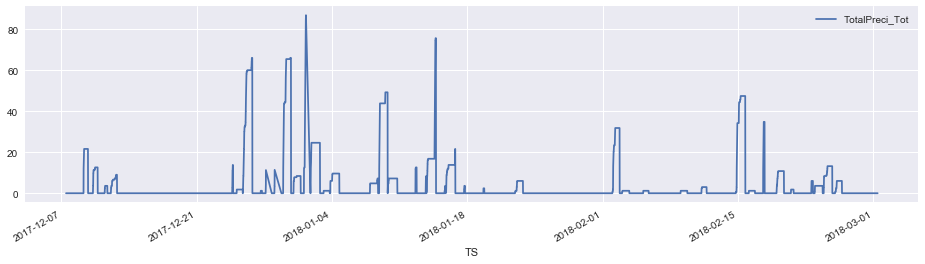

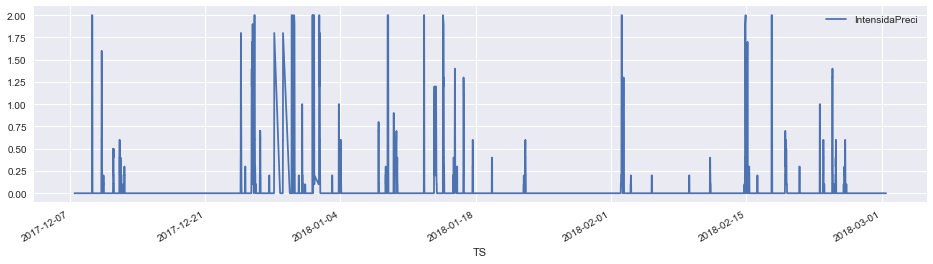

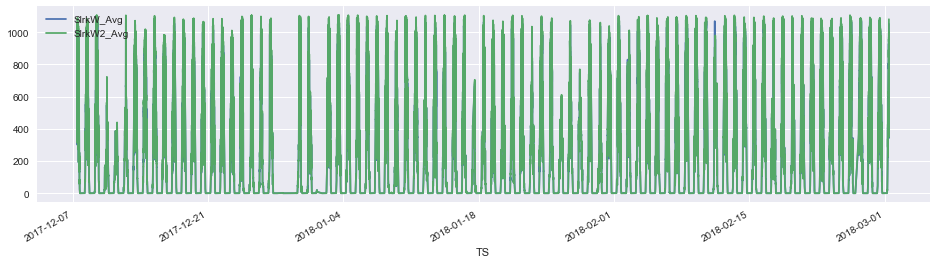

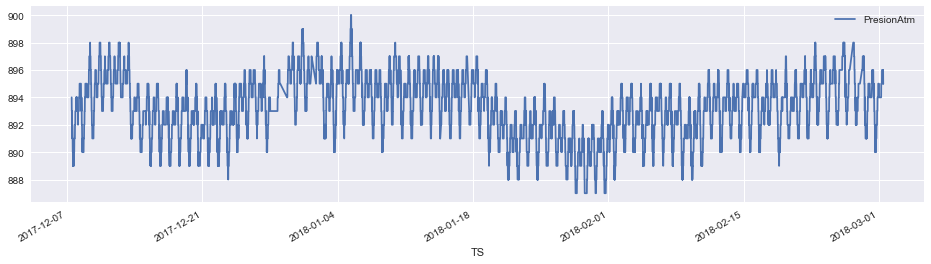

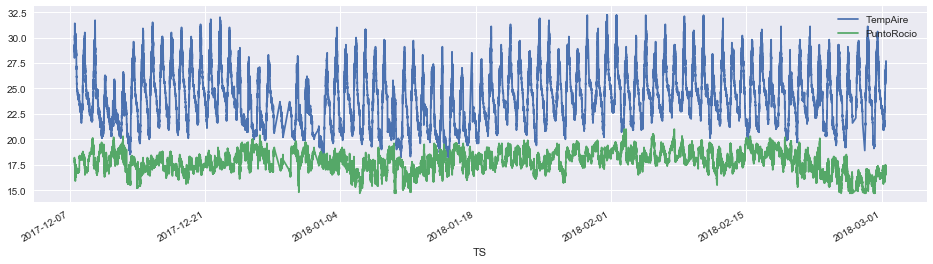

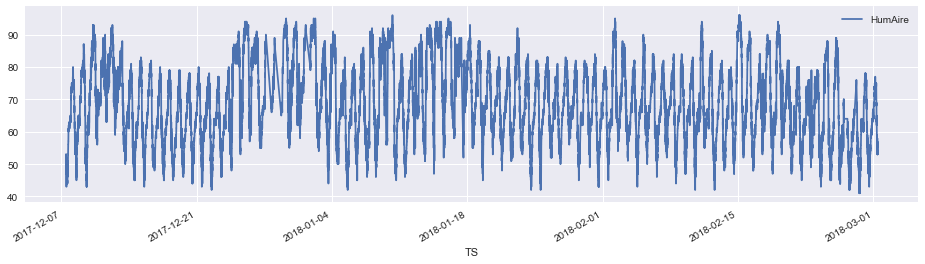

In [4]:


z_data = data.apply(lambda df: (df-df.mean())/df.std(ddof=0))
data_nout = data[(np.abs(z_data) < 3).all(axis=1)]
display(data_nout)
units = set([c['units'] for v, c in variables.items()])
for u in units:
    if u not in ['Degree', 'm/s']:
        vs = [k for k, v in variables.items() if v['units']==u]
        vs = [v for v in vs if v in data_nout.columns]
        print(vs)
        ax = data_nout[vs].plot()
        ax.set_ylabel = u
        #display(ax)




## Gráficos vientos ##

n_headings 8


,compass point,heading,level,traditional wind point,heading_rad,Nivel 0,Nivel 1,Nivel 2
point,,,,,,,,
N,North,0,0,Tramontana,0.000000,0.035675,0.026665,0.011254
NE,Northeast,45,1,Greco,0.785398,0.037980,0.037526,0.010914
E,East,90,0,Levante,1.570796,0.043123,0.041787,0.010250
SE,Southeast,135,1,Scirocco,2.356194,0.036819,0.022622,0.003274
S,South,180,0,Ostro,3.141593,0.044214,0.023661,0.004008
SW,Southwest,225,1,Libeccio,3.926991,0.037657,0.023731,0.014555
W,West,270,0,Ponente,4.712389,0.051784,0.091650,0.168528
NW,Northwest,315,1,Maestro,5.497787,0.043132,0.062131,0.117058


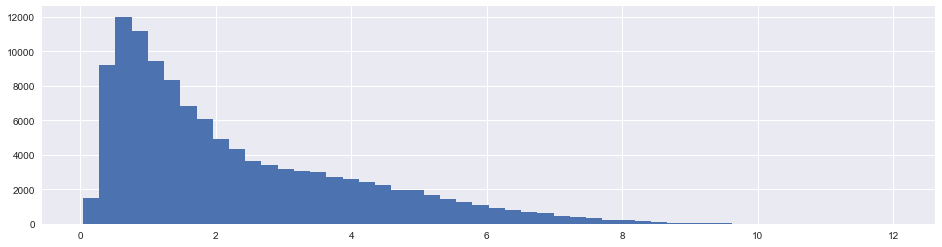

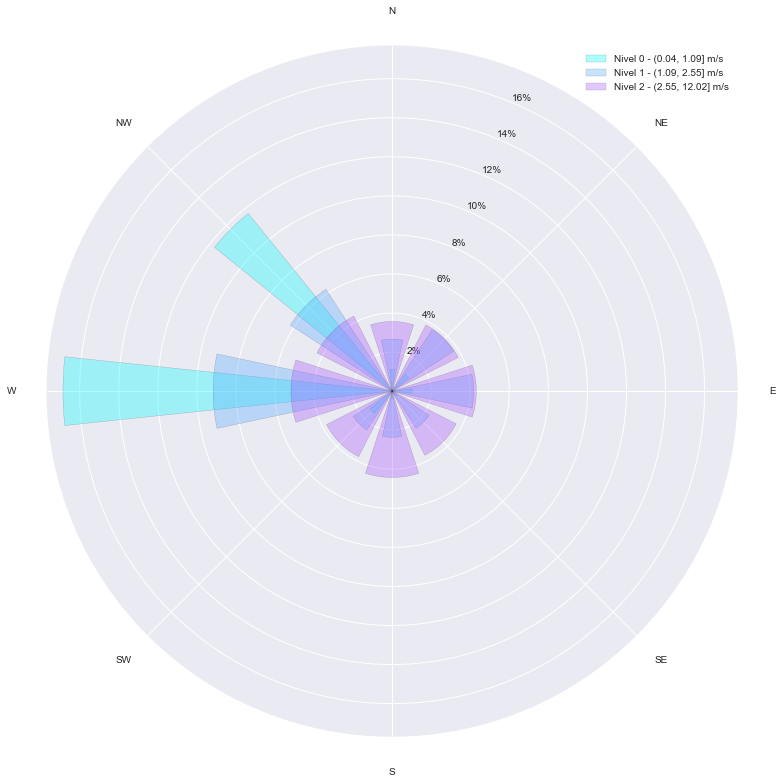

In [5]:
data_nout['VelocidadViento_Avg'].hist(bins=50)

#quantiles = [0, .2, .4, .6, .8, 1]
quantiles = [0, .33, .66, 1]
ws_names = [f"Nivel {i}" for i in range(len(quantiles)-1)]
                                        
ws_edges = data_nout['VelocidadViento_Avg'].quantile(quantiles).tolist()        
#ws_edges = [0, 3.5, 14, 25, 100]
wind_speed_cats = {
    'names': ws_names,
    'edges': ws_edges,
}


comp = compass[compass['level'] <= 1].copy()
                                        
res = plot_wind(data_nout, comp, wind_speed_cats, 'VelocidadViento_Avg', 'DireccionViento')
display(res)
    